# Temperatures

This is an assignment for my thinkful data science course - "Temperatures"
Raj Prasad
May 2019


[html version](https://daddyprasad5.github.io/Temperatures.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/Temperatures.ipynb) - with all the code exposed in an interactive notebook

## Temperatures dataset

I'm demonstrating a linear regression modeling on a weather dataset originally from Kaggle. This dataset consists of 12 varibles describing hourly weather observations Szeged, Hungary area, between 2006 and 2016. You can find the descriptions of the variables [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

The target variable will be the "Temperature (C)". Since it's a continuous variable, we're dealing with a regression task.

(BTW: I didn't use the suggested variables in the assignment, but rather played around with picking variables of my own for kicks.)

In [1]:
#imports & connection
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
import scipy.stats as stats
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import warnings
warnings.filterwarnings('ignore')

In [2]:
#db connection
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [3]:
#data load
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [4]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [6]:
weather_df.describe(include="O")

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085


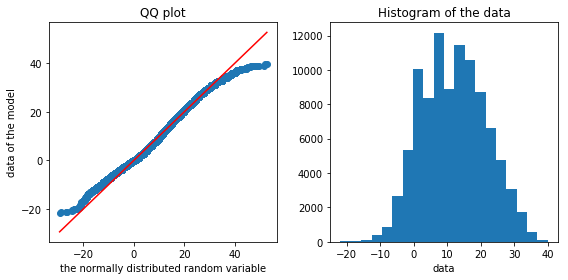

Jarque-Bera test statistics is 1433.6419797355063 and p value is 0.0
Normality test statistics is 2781.3146430107663 and p value is 0.0


In [7]:
# target variable distribution


def check_normality(data): 
    rand_nums = np.random.normal(np.mean(data), np.std(data), len(data))

    plt.figure(figsize=(8,4))
    
    x = np.sort(rand_nums)
    y = data.sort_values()

    plt.subplot(1,2,1)
    plt.scatter(np.sort(rand_nums), data.sort_values())
    plt.xlabel("the normally distributed random variable")
    plt.ylabel("data of the model")
    plt.plot(x, x, c="red")
    plt.title("QQ plot")

    plt.subplot(1,2,2)
    plt.hist(data, bins = 20)
    plt.xlabel("data")
    plt.title("Histogram of the data")

    plt.tight_layout()
    plt.show()

    from scipy.stats import jarque_bera
    from scipy.stats import normaltest

    jb_stats = jarque_bera(data)
    norm_stats = normaltest(data)

    print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
    print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))
    
check_normality(weather_df.temperature)

We observe that temperature distribution is normal like, but fails statistical normatiliy tests.  

In [8]:
#there are no missing values.  nice.

def find_nulls(df): 
    total_missing = df.isnull().sum().sort_values(ascending=False)
    percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    

def remove_null_cols(df):
    n = len(df)
    cols = df.columns
    null_cols = [(len(df[df[col].isnull()]) == 0) for col in df]
    return df.iloc[:, null_cols]

find_nulls(weather_df)

,Total,Percent
dailysummary,0,0.0
pressure,0,0.0
loudcover,0,0.0
visibility,0,0.0
windbearing,0,0.0
windspeed,0,0.0
humidity,0,0.0
apparenttemperature,0,0.0
temperature,0,0.0
preciptype,0,0.0


In [9]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [10]:
#get all the continuous and categorical columns
# from itertools import compress

cat_cols = ['summary', 'preciptype', 'dailysummary']
cont_cols = ['temperature', 'apparenttemperature', 'humidity', 'windspeed', 
            'windbearing', 'visibility', 'loudcover', 'pressure']


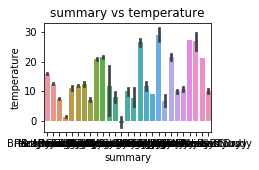

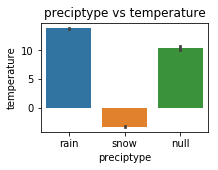

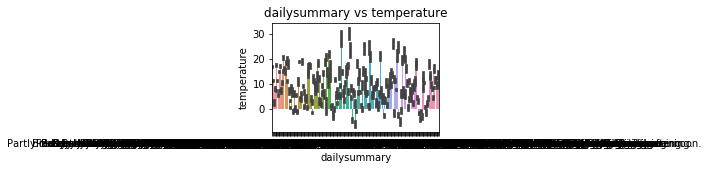

In [11]:
#for categorical variables - get a visual on which variables split the target variable

def cat_to_cont(df, cat, cont, threshold):
    """creates a barplot and conducts t-test 
    for a categorical to continuous relationship"""


    #group by
    unique_vals = df[cat].unique()
    grouped_df = df[[cat, cont]].groupby(cat).mean()

    
    #barplot
    plt.figure(figsize=(3, 2))
    sns.barplot(df[cat], df[cont])
    plt.title("{} vs {}".format(cat, cont))
    plt.show()

    #t-test
#     for i in range(0, len(unique_vals)):
#         for j in range(i+1, len(unique_vals)):
#             t, p = stats.ttest_ind(
#                 df[df[cat]==unique_vals[i]][cont], 
#                 df[df[cat]==unique_vals[j]][cont])
#             if p < threshold: 
#                 print("t-test between groups {0} and {1} is significant:  p = {2}:"
#                       .format(unique_vals[i], unique_vals[j], p))


for cat in cat_cols: 
     cat_to_cont(weather_df, cat, "temperature", .05)

In [12]:
#transform the promising categorical variables to one-hot columns and create a features dataframe
preciptype_df = pd.get_dummies(weather_df.preciptype, prefix='preciptype', drop_first=True)

features = pd.concat([preciptype_df],axis=1)


In [13]:
#find some powerful continuous variables

#take the 5 with the highest correlation with sales price 
cont_corrs = np.abs(weather_df[cont_cols].iloc[:,0:].corr().loc[:,"temperature"]).sort_values(ascending=False)
top_cont = cont_corrs[1:10].index.values

#add the new columns to the features dataframe
for cont in top_cont: 
    features[cont] = weather_df[cont]

print(features.columns)

Index(['preciptype_rain', 'preciptype_snow', 'apparenttemperature', 'humidity',
       'visibility', 'windbearing', 'windspeed', 'pressure', 'loudcover'],
      dtype='object')


## An initial model for home prices

Build a simple linear regression model using all of our promising one-hot features (including some highly-correlated features) and estimate it using OLS. 

In [14]:
# a first model...
# Y is the target variable
Y = weather_df['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

lrm = sm.OLS(Y, X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.210e+06
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        15:06:29   Log-Likelihood:            -1.3176e+05
No. Observations:               96453   AIC:                         2.635e+05
Df Residuals:                   96444   BIC:                         2.636e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4354      0.055     44.533      0.000       2.328       2.543
preciptype_rain         0.3622      0.042      8.636      0.000       0.280       0.444
preciptype_snow         0.4202      0.043      9.736      0.000       0.336       0.505
apparenttemperature     0.8736      0.000   1930.995      0.000       0.873       0.875
humidity               -1.4008      0.022    -64.749      0.000      -1.443      -1.358
visibility              0.0086      0.001     10.497      0.000       0.007       0.010
windbearing            -0.0004   2.87e-05    -14.120      0.000      -0.000      -0.000
windspeed               0.0802      0.000    166.879      0.000       0.079       0.081
pressure               -0.0002   2.62e-05     -7.737      0.000      -0.000      -0.000
loudcover                    0          0        nan        nan           0           0
==============================================================================
Omnibus:                     4028.676   Durbin-Watson:                   0.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4901.563
Skew:                          -0.467   Prob(JB):                         0.00
Kurtosis:                       3.589   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
#1. linearity of models in their coefficients - the model chosen de facto satisfies this condition

In [16]:
#2. the error term should be zero on average - and it is very close.  No concerns here. 
#predictions = results.fittedvalues
predictions = results.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -1.103240750494361e-14


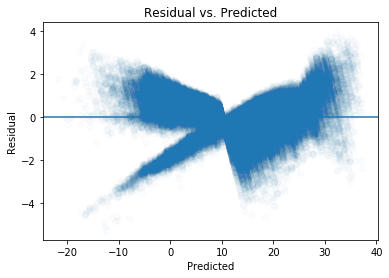

Bartlett test statistic value is 312768 and p value is 0
Levene test statistic value is 182717 and p value is 0


In [17]:
#3. homoscedasticity: the errors are consistently distributed  
plt.scatter(predictions, errors, alpha = .02)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

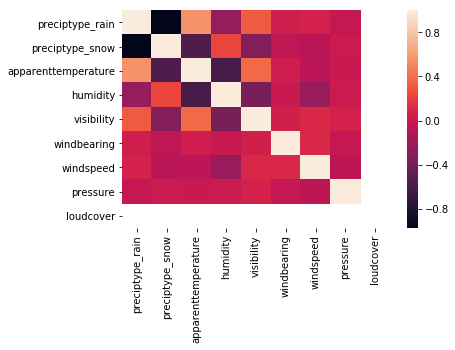

In [18]:
#4. low multicollinearity - THERE IS ONE HIGHLY CORRELATED FEATURE PAIRS. 
sns.heatmap(features.corr())
plt.show()

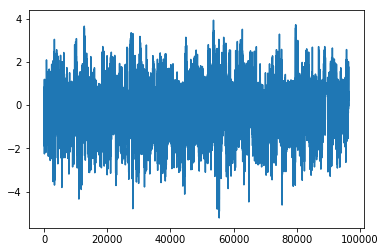

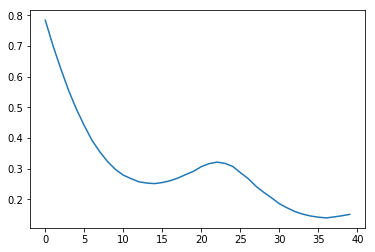

In [19]:
#5. ERROR TERMS ARE HIGHLY CORRELATED WITH EACH OTHER 
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [20]:
#6. features shouldn't be correlated with the errors - and they aren't

f_err_corrs = [abs(features[feature].corr(errors)) for feature in features.columns]

high_corrs = [(x > 0.1) for x in f_err_corrs]

high_errs_df = pd.DataFrame([features.columns, f_err_corrs]).transpose()[high_corrs]
high_errs_df.columns = ["feature", "correlation with error >0.1"]
high_errs_df

,feature,correlation with error >0.1


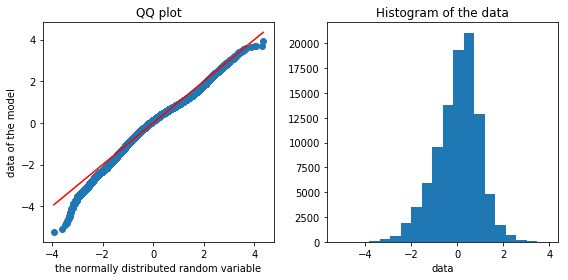

Jarque-Bera test statistics is 4901.56311745998 and p value is 0.0
Normality test statistics is 4028.6760572395083 and p value is 0.0


In [21]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

check_normality(errors)

We've found these concerns:  

* There is one highly correlated feature pair (rain / snow). (remove a feature)
* Error terms are highly correlated with each other (add a feature)
* The errors are not normally distributed (add a feature)

To mitigate these issues, let's remove rain and add two new variables for the hour of the day and month of the year.   

In [22]:
#drop rain
features = features.drop("preciptype_rain", axis=1)

In [23]:
#add hour and month
month = [d.month for d in pd.DatetimeIndex(weather_df.date)]
hour = [d.hour for d in pd.DatetimeIndex(weather_df.date)]
features["hour"] = hour
features["month"] = month
features.head()

,preciptype_snow,apparenttemperature,humidity,visibility,windbearing,windspeed,pressure,loudcover,hour,month
0,0,7.388889,0.89,15.8263,251.0,14.1197,1015.13,0.0,22,3
1,0,7.227778,0.86,15.8263,259.0,14.2646,1015.63,0.0,23,3
2,0,9.377778,0.89,14.9569,204.0,3.9284,1015.94,0.0,0,4
3,0,5.944444,0.83,15.8263,269.0,14.1036,1016.41,0.0,1,4
4,0,6.977778,0.83,15.8263,259.0,11.0446,1016.51,0.0,2,4


In [24]:
#re-run the model
# Y is the target variable
Y = weather_df['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = features

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

lrm = sm.OLS(Y, X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.075e+06
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        15:06:38   Log-Likelihood:            -1.3178e+05
No. Observations:               96453   AIC:                         2.636e+05
Df Residuals:                   96443   BIC:                         2.637e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.7640      0.037     74.759      0.000       2.692       2.836
preciptype_snow         0.0676      0.012      5.481      0.000       0.043       0.092
apparenttemperature     0.8732      0.000   1899.283      0.000       0.872       0.874
humidity               -1.4152      0.022    -64.311      0.000      -1.458      -1.372
visibility              0.0096      0.001     11.617      0.000       0.008       0.011
windbearing            -0.0004   2.87e-05    -13.983      0.000      -0.000      -0.000
windspeed               0.0803      0.000    166.801      0.000       0.079       0.081
pressure               -0.0002   2.62e-05     -7.781      0.000      -0.000      -0.000
loudcover            1.496e-15   2.91e-17     51.318      0.000    1.44e-15    1.55e-15
hour                -1.004e-05      0.000     -0.022      0.982      -0.001       0.001
month                   0.0054      0.001      5.861      0.000       0.004       0.007
==============================================================================
Omnibus:                     3958.361   Durbin-Watson:                   0.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4791.247
Skew:                          -0.464   Prob(JB):                         0.00
Kurtosis:                       3.576   Cond. No.                     5.27e+20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.66e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [25]:
#2. the error term should be zero on average - and it is very close.  No concerns here. 
#predictions = results.fittedvalues
predictions = results.predict(X)
errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: 4.608741088149574e-14


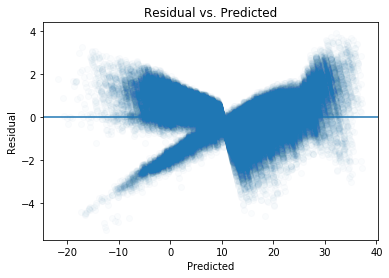

Bartlett test statistic value is 312728 and p value is 0
Levene test statistic value is 182580 and p value is 0


In [26]:
#3. homoscedasticity: the errors are consistently distributed  
plt.scatter(predictions, errors, alpha = .02)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

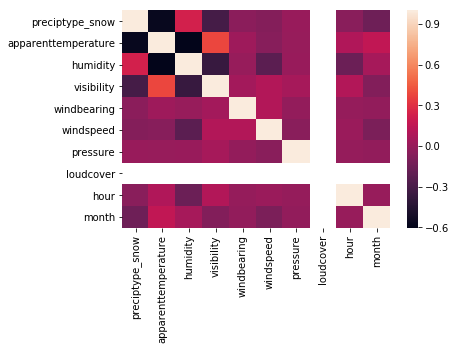

In [27]:
#4. low multicollinearity - looks better. 
sns.heatmap(features.corr())
plt.show()

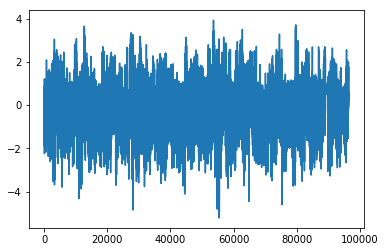

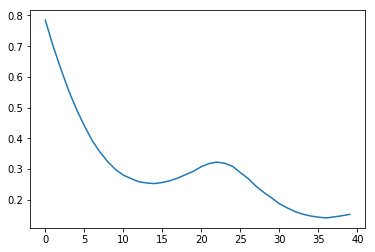

In [28]:
#5. ERROR TERMS ARE STILL HIGHLY CORRELATED WITH EACH OTHER 
plt.plot(errors)
plt.show()

from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [29]:
#6. features shouldn't be correlated with the errors - and they aren't

f_err_corrs = [abs(features[feature].corr(errors)) for feature in features.columns]

high_corrs = [(x > 0.1) for x in f_err_corrs]

high_errs_df = pd.DataFrame([features.columns, f_err_corrs]).transpose()[high_corrs]
high_errs_df.columns = ["feature", "correlation with error >0.1"]
high_errs_df

,feature,correlation with error >0.1


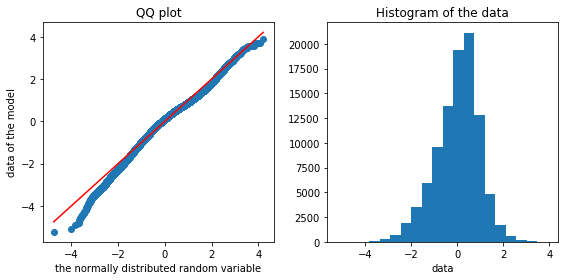

Jarque-Bera test statistics is 4791.246810979072 and p value is 0.0
Normality test statistics is 3958.361184549315 and p value is 0.0


In [30]:
#7. ERRORS ARE NOT NORMALLY DISTRIBUTED. 

check_normality(errors)

Removing "rain" resolved the multi-colinearity concern.

However, even after adding two more variables (hour and month), I'm not seeing any improvement in error normality or auto-correlation.  